## Linear Regression Final Project: Logistic Regression with Traffic Collision Data
### Zachary Barnes and Bing Wang

##### Housekeeping

In [1]:
# Load Python libraries
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import matplotlib.pyplot as plt
from scipy.stats import chi2, chi2_contingency

# Run R code adjacent to Python code
%load_ext rpy2.ipython

# Load ggplot R library
%R library(ggplot2)
%R library(scales)

# Avoid kernal death
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Read in and organize data from TIMS (Collisions and Victims)

#### Collisions data

In [2]:
c = pd.read_csv("Collisions.csv")

Response variable: Collision severity. We will code this as a binary variable, with 1 = fatality and 0 = not a fatality

Keep a subset of predictors as full model: Based on previous knowledge, these are likely to be predictors of collision severity

In [3]:
c = c[['CASE_ID', 'COLLISION_TIME','INTERSECTION','COLLISION_SEVERITY',
       'ROAD_SURFACE', 'ROAD_COND_1', 'PEDESTRIAN_ACCIDENT',
       'BICYCLE_ACCIDENT', 'MOTORCYCLE_ACCIDENT', 'ALCOHOL_INVOLVED']]

Make datetime variables

In [4]:
# Convert COLLISION_TIME to hour of day (use tlater to match speeds to collisions)
c['COLLISION_TIME'] = [int(i[:-2]) if len(i) > 2 else 0 for i in c['COLLISION_TIME'].astype(str).values]

c.sample(5)

,CASE_ID,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,BICYCLE_ACCIDENT,MOTORCYCLE_ACCIDENT,ALCOHOL_INVOLVED
1085,8744790,7,N,4,A,-,NaN,NaN,NaN,NaN
1029,8754647,11,Y,3,A,H,NaN,NaN,NaN,NaN
2805,8594831,20,Y,3,B,H,Y,NaN,NaN,NaN
1044,8749788,12,N,4,A,H,NaN,NaN,NaN,NaN
3399,8552748,12,Y,4,A,H,Y,NaN,NaN,NaN


In [5]:
# recode variables in Collision (as 1s and 0s, reduce categories down, make dummies)

# NOTE: ROAD_SURFACE and ROAD_COND_1 had some observations unstated
# If not stated, assumed no issues with road surface or con'd

# Intersection: Make dummy, intersection/not
c.loc[~(c.INTERSECTION == "Y"), "INTERSECTION"] = 0
c.loc[c.INTERSECTION == "Y", "INTERSECTION"] = 1


# Road_Surface: Convert to dummy, wet/not 
c.loc[~(c.ROAD_SURFACE.isin(["B", "C", "D"])), "WET_ROAD_SURFACE"] = 0
c.loc[c.ROAD_SURFACE.isin(["B", "C", "D"]), "WET_ROAD_SURFACE"] = 1


# Road_Cond_1: Convert to dummy, issue/not
c.loc[~(c.ROAD_COND_1.isin(["H", ""])), "ROAD_COND_ISSUE"] = 1
c.loc[c.ROAD_COND_1.isin(["H", ""]), "ROAD_COND_ISSUE"] = 0

Recode some variables

In [6]:
# for dummies: recode Y as 1, blank as 0
def Yfor1(s):
    s = s.replace("Y", 1)
    s = s.fillna(0)
    return s

In [7]:
c["PEDESTRIAN_ACCIDENT"] = Yfor1(c.PEDESTRIAN_ACCIDENT)
c["BICYCLE_ACCIDENT"] = Yfor1(c.BICYCLE_ACCIDENT)
c["MOTORCYCLE_ACCIDENT"] = Yfor1(c.MOTORCYCLE_ACCIDENT)
c["ALCOHOL_INVOLVED"] = Yfor1(c.ALCOHOL_INVOLVED)

Make response binary variable from Collision_Severity: 1 for fatality (COLLISION_SEVERITY = 1), 0 for not fatality (COLLISION_SEVERITY != 1)

In [8]:
c.loc[c.COLLISION_SEVERITY == 1, "Fatality"] = 1
c.loc[c.COLLISION_SEVERITY != 1, "Fatality"] = 0

Drop vars we won't use

In [9]:
c = c[['CASE_ID','Fatality', 'COLLISION_TIME','INTERSECTION', 'PEDESTRIAN_ACCIDENT','BICYCLE_ACCIDENT',
       'MOTORCYCLE_ACCIDENT','WET_ROAD_SURFACE','ROAD_COND_ISSUE']]

In [10]:
c.sample(5)

,CASE_ID,Fatality,COLLISION_TIME,INTERSECTION,PEDESTRIAN_ACCIDENT,BICYCLE_ACCIDENT,MOTORCYCLE_ACCIDENT,WET_ROAD_SURFACE,ROAD_COND_ISSUE
368,8777315,0.0,23,1,0.0,0.0,0.0,0.0,0.0
1616,8692663,0.0,8,0,0.0,0.0,0.0,0.0,0.0
3180,8557541,0.0,20,1,0.0,0.0,1.0,0.0,0.0
1692,8685863,0.0,13,0,0.0,1.0,0.0,0.0,0.0
704,8758186,0.0,14,0,0.0,0.0,0.0,0.0,0.0


## Exploratory Data Analysis

0.0    3846
1.0      24
Name: Fatality, dtype: int64


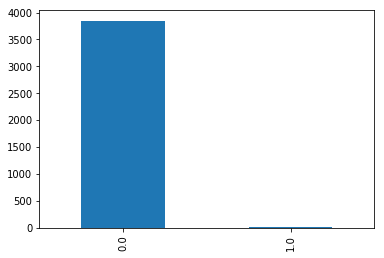

In [11]:
# value counts of response variable
print(c["Fatality"].value_counts())

c["Fatality"].value_counts().plot(kind='bar')

There are way more Fatality == 1 observations than Fatality == 0 observations. 

In making side-by-side bar plots of value counts of predictors' values when response == 1 and response == 0, let's only show plots with response = Fatality == 1, since otherwise, the overwhelming size of observations with Fatality == 0 would overwhelm the size of bars with Fatality == 0.

In [13]:
# get list of all possible predictors
pred_col = [col for col in c.columns if col != "CASE_ID" and col != "Fatality"]
pred_col

['COLLISION_TIME',
 'INTERSECTION',
 'PEDESTRIAN_ACCIDENT',
 'BICYCLE_ACCIDENT',
 'MOTORCYCLE_ACCIDENT',
 'WET_ROAD_SURFACE',
 'ROAD_COND_ISSUE']

Text(0.5, 0.98, 'Value counts for predictors when Fatality = 1')

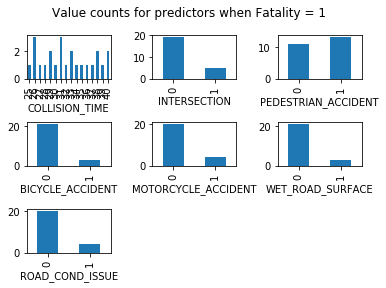

In [14]:
fig = plt.figure()
fig.subplots_adjust(hspace=1, wspace=0.5)
for i, col in enumerate(pred_col, start = 1):
    plt.subplot(3, 3, i)
    cfp = c[["Fatality", col, "CASE_ID"]].groupby(["Fatality", col]).count().reset_index()
    cfp.loc[cfp.Fatality == 1]["CASE_ID"].plot(kind='bar')
    if col!="COLLISION_TIME":
        plt.xticks(np.arange(0,2), (0, 1))
    plt.xlabel(col)
fig.suptitle("Value counts for predictors when Fatality = 1")
    
# these are value counts for each predictor when Fatality = 1

Text(0.5, 0.98, 'Value counts for predictors when Fatality = 0')

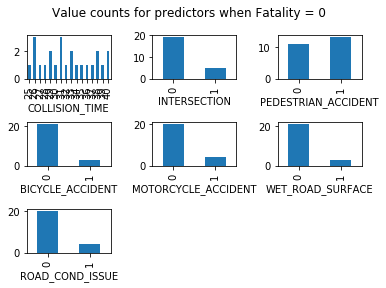

In [15]:
fig = plt.figure()
fig.subplots_adjust(hspace=1, wspace=0.5)
for i, col in enumerate(pred_col, start = 1):
    plt.subplot(3, 3, i)
    cfp = c[["Fatality", col, "CASE_ID"]].groupby(["Fatality", col]).count().reset_index()
    cfp.loc[cfp.Fatality == 1]["CASE_ID"].plot(kind='bar')
    if col!="COLLISION_TIME":
        plt.xticks(np.arange(0,2), (0, 1))
    plt.xlabel(col)
fig.suptitle("Value counts for predictors when Fatality = 0")
    
# these are value counts for each predictor when Fatality = 0

In [16]:
# print out value counts (values of the bar figures above)
for i, col in enumerate(pred_col, start = 1):
    cfp = c[["Fatality", col, "CASE_ID"]].groupby(["Fatality", col]).count().reset_index()
    print(col)
    print(cfp)
    print("\n")

COLLISION_TIME
    Fatality  COLLISION_TIME  CASE_ID
0        0.0               0       68
1        0.0               1       69
2        0.0               2       71
3        0.0               3       36
4        0.0               4       47
5        0.0               5       38
6        0.0               6       81
7        0.0               7      156
8        0.0               8      237
9        0.0               9      195
10       0.0              10      175
11       0.0              11      200
12       0.0              12      190
13       0.0              13      202
14       0.0              14      246
15       0.0              15      259
16       0.0              16      245
17       0.0              17      303
18       0.0              18      256
19       0.0              19      188
20       0.0              20      167
21       0.0              21      158
22       0.0              22      133
23       0.0              23      124
24       0.0              25       

Based on this data exploration, it looks like PEDESTRIAN_ACCIDENT may be a promising predictor: Given Fatality == 1, there are more observations with PEDESTRIAN_ACCIDENT == 1 than observations with PEDESTRIAN_ACCIDENT == 0.

It is unclear from initial exploration which other variables might be important predictors.

## Model Selection 

In [17]:
def forward_selected(data, response, aic_or_bic):
    """Logistic model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by AIC or BIC
    """
    remaining = set(data.columns) 
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 9999, 9999  # set starting point scores really high: want low AIC
    
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        # regress response ~ prior selected predictors + each remaining predictor individually
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            # do aic or bic score, depending on if you specified aic or bic in args
            if aic_or_bic == "AIC":
                score = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit().aic 
            elif aic_or_bic == "BIC":
                score = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit().bic
            else:
                raise ValueError("Did not specify aic_or_bic = 'AIC' or 'BIC' in args")
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    
    # final selected model from stepwise selection
    formula = "{} ~ {} + 1".format(response,' + '.join(selected))
    model = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
    return model

Model chosen by best AIC:

In [31]:
model1 = forward_selected(c,'Fatality', "AIC")

In [32]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Fatality   No. Observations:                 3870
Model:                            GLM   Df Residuals:                     3866
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -132.35
Date:                Sat, 12 Oct 2019   Deviance:                       264.71
Time:                        18:19:16   Pearson chi2:                 3.12e+03
No. Iterations:                     9   Covariance Type:             nonrobust
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -5.2741      0.323    -16.312      0.000      -5.908      -4.640
PEDESTRIAN_ACCIDENT     1.6459      0.416      3.956      0.000       0.830       2.461
INTERSECTION           -1.5631      0.509     -3.072      0.002      -2.560      -0.566
ROAD_COND_ISSUE         1.2175      0.560      2.176      0.030       0.121       2.314
=======================================================================================
"""

Model selected by best BIC:

In [33]:
model2 = forward_selected(c,'Fatality', "BIC")

In [35]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Fatality   No. Observations:                 3870
Model:                            GLM   Df Residuals:                     3867
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -134.18
Date:                Sat, 12 Oct 2019   Deviance:                       268.37
Time:                        18:19:35   Pearson chi2:                 3.50e+03
No. Iterations:                     9   Covariance Type:             nonrobust
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -5.1657      0.312    -16.532      0.000      -5.778      -4.553
PEDESTRIAN_ACCIDENT     1.6662      0.416      4.008      0.000       0.851       2.481
INTERSECTION           -1.5367      0.508     -3.022      0.003      -2.533      -0.540
=======================================================================================
"""

AIC chose model1 = Fatality ~ PEDESTRIAN_ACCIDENT + INTERSECTION + ROAD_COND_ISSUE

BIC chose model2 = Fatality ~ PEDESTRIAN_ACCIDENT + INTERSECTION 

(makes sense: AIC and BIC work similarly but BIC penalizes model complexity/number of predictors more)

In this model selection, AIC selected a model with a subset of predictors of BIC's model. Let BIC-selected model = model2 = full model, and AIC-selected model = model1 = reduced model going forward.

**Wald test:** 
<br>Check p-values in regression summary. For both full and reduced models, all predictors are significant by Wald test (p-values < alpha = 0.05)

**Deviance test:** 
<br>Let's check whether we should do reduced model or full model.

H0: Reduced model 
<br>Ha: Full model
<br>$\Delta G^{2}$ = $G^{2}$(reduced model) − $G^{2}$(full model)

Compare against $\chi^{2}$($\alpha$ = 0.05, df = $p_{full}$ - $p_{reduced}$ = 3-2 = 1)

In [36]:
delta_G2 = model2.deviance - model1.deviance
delta_G2

3.6576426516627976

In [37]:
chi2.isf(0.05, 1)

3.8414588206941285

$\Delta G^{2}$ < $\chi^{2}$($\alpha$ = 0.05, df = 1): Fail to reject H0. 
<br>Thus, keep reduced model: model1 = Fatality ~ PEDESTRIAN_ACCIDENT + INTERSECTION

### Model selected: Fatality ~ PEDESTRIAN_ACCIDENT + INTERSECTION

# Model Diagnosis

### Check for influential points 

Get Pearson residuals from GLM results; make residual plot

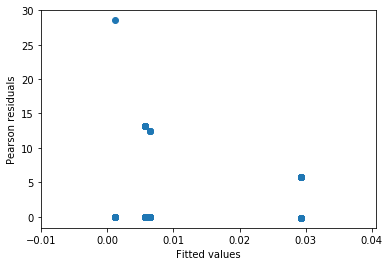

In [70]:
plt.scatter(model2.fittedvalues, model2.resid_pearson)
plt.xlabel("Fitted values")
plt.ylabel("Pearson residuals")
plt.show()

We expect residuals to largely sit in a band

Get hat matrix diagonals to detect points of high leverage

In [71]:
# need to run GLM to get_influence()
formula = "Fatality ~ PEDESTRIAN_ACCIDENT + INTERSECTION"

y, X = patsy.dmatrices(formula, data = c)

In [82]:
model1_GLM = sm.GLM(y, X,
        data=c, family=sm.families.Binomial()).fit()
model1_GLM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Fatality   No. Observations:                 3870
Model:                            GLM   Df Residuals:                     3867
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -134.18
Date:                Sat, 12 Oct 2019   Deviance:                       268.37
Time:                        20:15:57   Pearson chi2:                 3.50e+03
No. Iterations:                     9   Covariance Type:             nonrobust
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -5.1657      0.312    -16.532      0.000      -5.778      -4.553
PEDESTRIAN_ACCIDENT     1.6662      0.416      4.008      0.000       0.851       2.481
INTERSECTION           -1.5367      0.508     -3.022      0.003      -2.533      -0.540
=======================================================================================
"""

In [85]:
model1_GLM.get_influence().hat_matrix_diag

AttributeError: 'GLMResults' object has no attribute 'get_influence'